# Output variable -> Whether the client has subscribed a term deposit or not 

   Input variables:  
   
   bank client data:  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",  
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")  
     
   related with the last contact of the current campaign:  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)  
    
  other attributes:   
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")  
  
  Output variable (desired target):  
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")  

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, roc_curve, RocCurveDisplay
from sklearn.preprocessing import Normalizer, StandardScaler

## Exploratory Data Analysis

In [2]:
# loading the data
df = pd.read_csv('bank-full.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


Data contains 45211 samples and 16 features excluding the dependent variable 'y'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


There are no null values, 7 features are numeric, and 9 features are categorical

In [4]:
df.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [5]:
df.y[df.y == 'yes'].size / df.y.size

0.11698480458295547

The dependent variable's desired outcome is only 11% of the the entire data. This makes the data unbalanced. We will have to use class_weight = 'balanced' as a parameter to the Logistic Classifier

In [6]:
# Converting the dependent variable to a binary integer data type
df.y.replace({'yes':1, 'no':0}, inplace = True)

### EDA and Transformations with categorical features

In [7]:
# checking which features have only two values so that we can convert them to binary integer data types
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

We can see that 'default', 'housing', and 'loan' have only two unique values

In [8]:
df.default.value_counts()

no     44396
yes      815
Name: default, dtype: int64

In [9]:
df.groupby(['default', 'y']).size()

default  y
no       0    39159
         1     5237
yes      0      763
         1       52
dtype: int64

Only 52 of the nearly 45,000 samples have defaulted on their payments and yet have take the term deposits

<Axes: xlabel='default', ylabel='Count'>

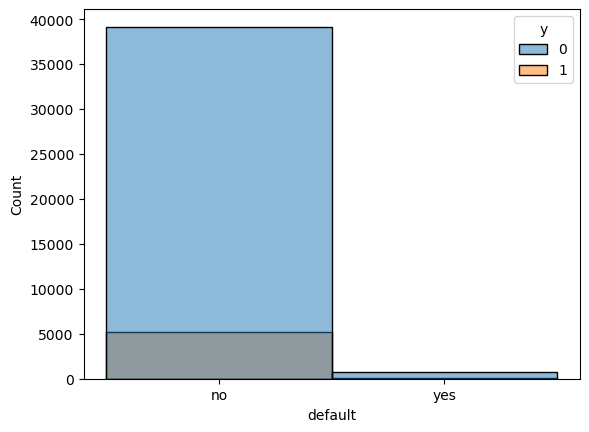

In [10]:
sns.histplot(df, x = 'default', hue = 'y')

In [11]:
df.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [12]:
df.groupby(['housing', 'y']).size()

housing  y
no       0    16727
         1     3354
yes      0    23195
         1     1935
dtype: int64

<Axes: xlabel='housing', ylabel='Count'>

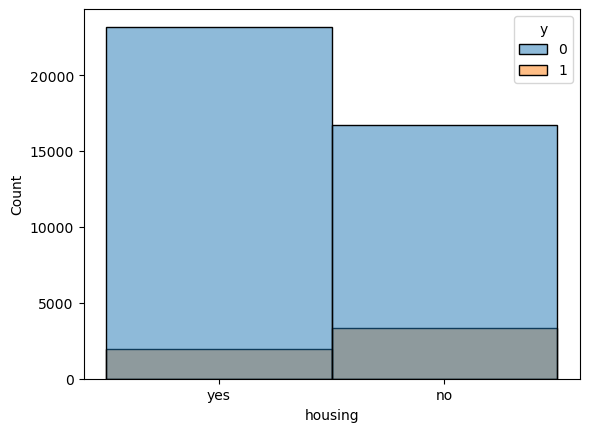

In [13]:
sns.histplot(df, x = 'housing', hue = 'y')

In [14]:
df.loan.value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

In [15]:
df.groupby(['loan','y']).size()

loan  y
no    0    33162
      1     4805
yes   0     6760
      1      484
dtype: int64

<Axes: xlabel='loan', ylabel='Count'>

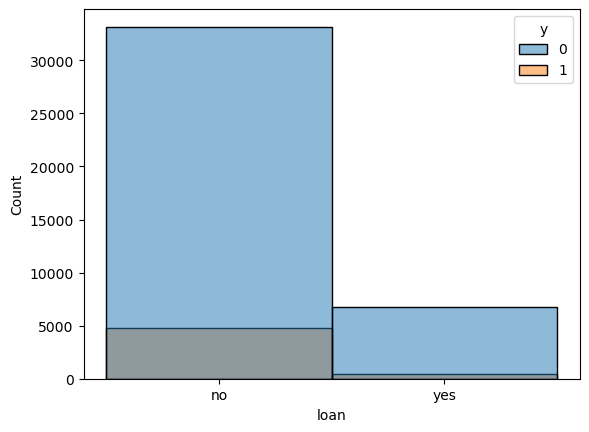

In [16]:
sns.histplot(df, x = 'loan', hue = 'y')

In [17]:
# converting features with only two labels into binary data
df.default.replace({'yes':1, 'no':0}, inplace = True)
df.housing.replace({'yes':1, 'no':0}, inplace = True)
df.loan.replace({'yes':1, 'no':0}, inplace = True)

In [18]:
# unique values in each categorical data type
df.select_dtypes('object').nunique()

job          12
marital       3
education     4
contact       3
month        12
poutcome      4
dtype: int64

In [19]:
df.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

<Axes: xlabel='marital', ylabel='Count'>

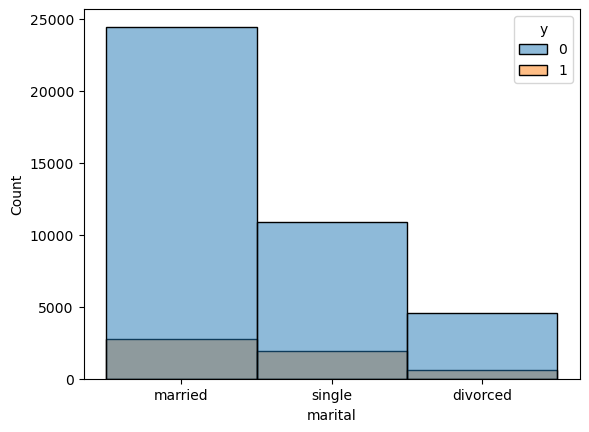

In [20]:
sns.histplot(df, x = 'marital', hue = 'y')

In [21]:
df.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

<Axes: xlabel='contact', ylabel='Count'>

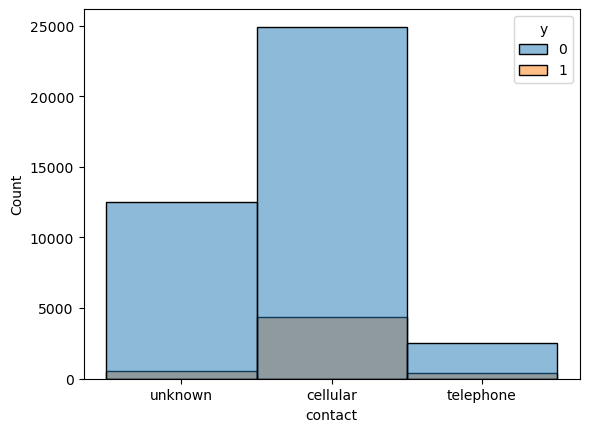

In [22]:
sns.histplot(df, x = 'contact', hue = 'y')

Unknown modes of contact still yield higher successful term deposits than telephone, so we will decide against considering them as na values, and keep it as a categorical value

In [23]:
df.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

<Axes: xlabel='education', ylabel='Count'>

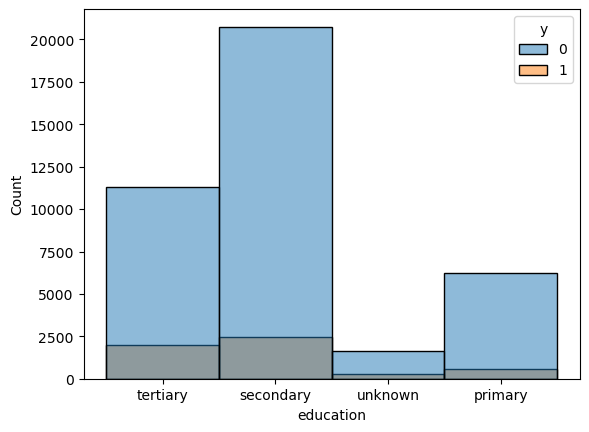

In [24]:
sns.histplot(df, x = 'education', hue = 'y')

unknown has a small share of positive term deposit values but not enough to discard them, so we will not turn them into na values

In [25]:
df.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

<Axes: xlabel='poutcome', ylabel='Count'>

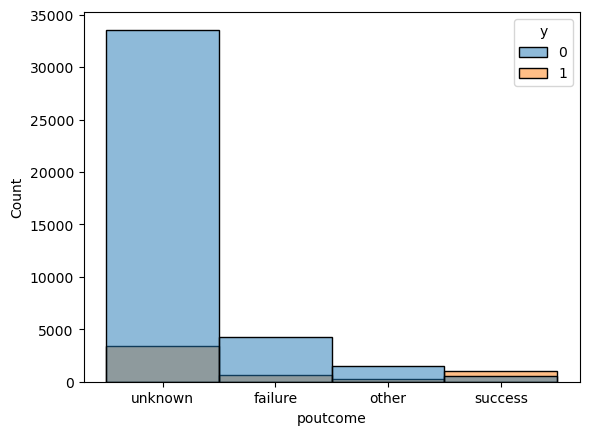

In [26]:
sns.histplot(df, x = 'poutcome', hue = 'y')

Unknown has the highest positive dependent value count, hence, we will retain it

In [27]:
df.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

<Axes: xlabel='Count', ylabel='job'>

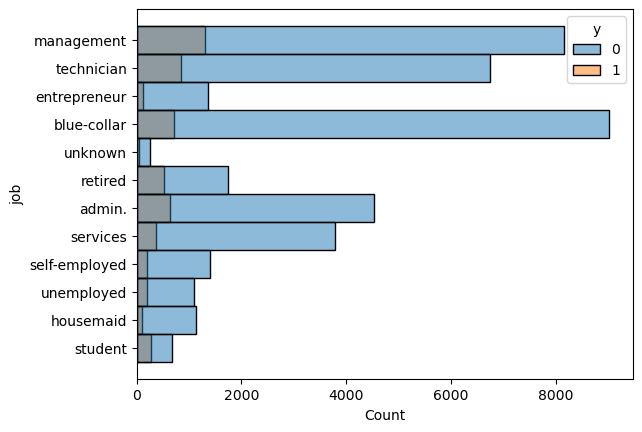

In [28]:
sns.histplot(df, y = 'job', hue = 'y')

In [29]:
df.month.value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

<Axes: xlabel='Count', ylabel='month'>

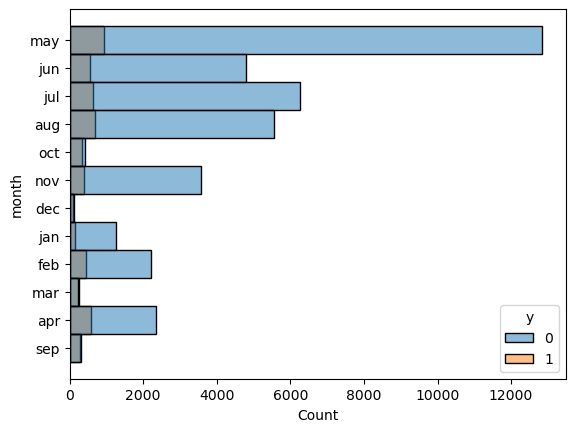

In [30]:
sns.histplot(df, y = 'month', hue = 'y')

month seems like a good indicator for classification

Before creating dummies for all categorical features, let's check correlation

C:\Users\harsh\AppData\Local\Temp\ipykernel_9560\2782132846.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, cmap = 'RdBu')


<Axes: >

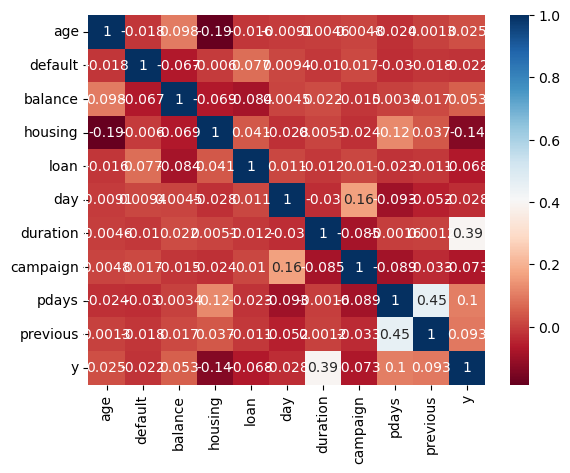

In [31]:
# getting a plot of correlation between all features
sns.heatmap(df.corr(), annot = True, cmap = 'RdBu')

There are no high correlations present

In [32]:
# getting a list of all categorical features
cat = df.select_dtypes('object').columns.to_list()

In [33]:
# creating dummies for all categorical variables
df = pd.get_dummies(df, columns = cat, drop_first=True)

In [34]:
# displaying list of all columns
df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

### EDA on numeric features

In [35]:
df.select_dtypes(['int','float']).columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y'],
      dtype='object')

Of these, default, housing, and loan are binary labelled features. Any y is our dependent variable. That leaves age, balance, day, duration, campaign, pdays, and previous are numeric features

<Axes: xlabel='age', ylabel='Count'>

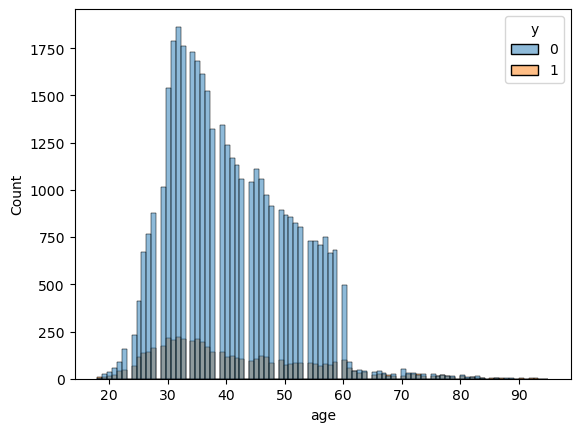

In [36]:
sns.histplot(df, x = 'age', hue = 'y')

<Axes: xlabel='balance', ylabel='Count'>

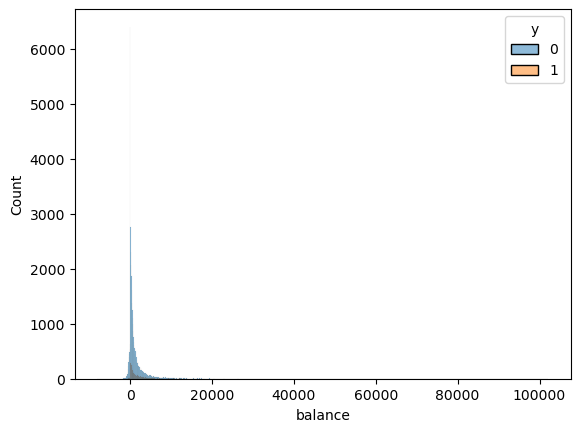

In [37]:
sns.histplot(df, x = 'balance', hue = 'y')

There seem to be outliers with high balance, but most customers have low balance, highly skewed data

<Axes: xlabel='day', ylabel='Count'>

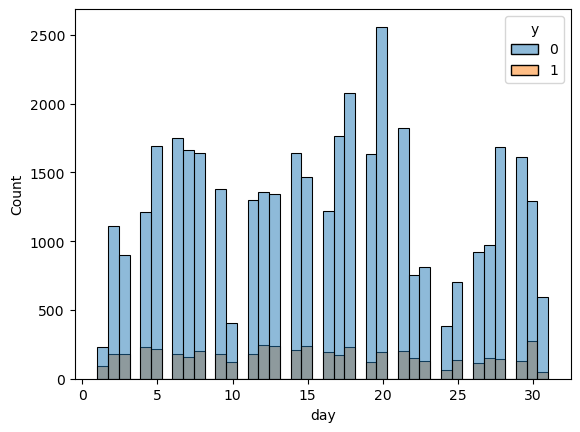

In [38]:
sns.histplot(df, x = 'day', hue = 'y')

day does not seem to be a good indicator for outcome

<Axes: xlabel='duration', ylabel='Count'>

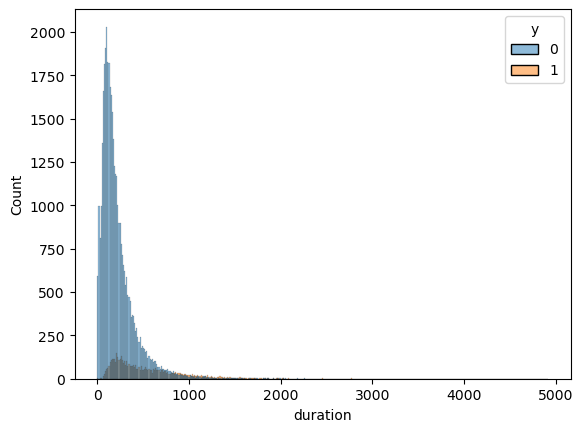

In [39]:
sns.histplot(df, x = 'duration', hue = 'y')

Duration seems to be a good indicator for outcome, but we can't use it as our model is supposed to predict who will take the term deposit, but we can't know that before the call end and we have this information. Hence, duration of the call will not be available to our model for new data. Hence we will drop this feature

In [40]:
df.drop(columns = 'duration', inplace = True)

<Axes: xlabel='campaign', ylabel='Count'>

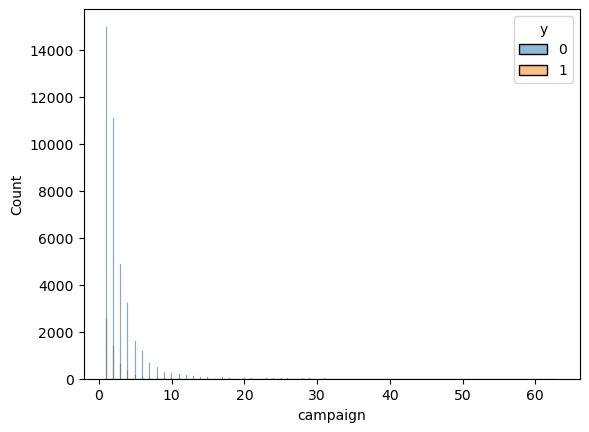

In [41]:
sns.histplot(df, x = 'campaign', hue = 'y')

highly skewed data

In [42]:
# getting successful term deposits for each unique value in campaign feature
df[df.y == 1].campaign.value_counts().sort_index()

1     2561
2     1401
3      618
4      317
5      139
6       92
7       47
8       32
9       21
10      14
11      16
12       4
13       6
14       4
15       4
16       2
17       6
20       1
21       1
24       1
29       1
32       1
Name: campaign, dtype: int64

Majority of the customers who agreed to a term deposit did so within 11 calls

<Axes: xlabel='pdays', ylabel='Count'>

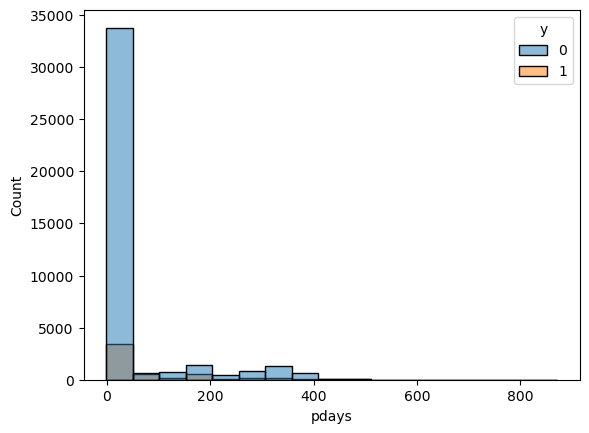

In [43]:
sns.histplot(df, x = 'pdays', hue = 'y')

In [44]:
df[df.y == 1].pdays.value_counts().sort_index()

-1      3384
 1         6
 2         2
 4         1
 6         1
        ... 
 804       1
 805       1
 828       1
 842       1
 854       1
Name: pdays, Length: 423, dtype: int64

-1 means the customer was not contacted before; data is skewed due to this

In [45]:
# getting the number of samples with no prior contact
df[df.pdays == -1].shape

(36954, 42)

Most customers were not contacted previously

<Axes: xlabel='pdays', ylabel='Count'>

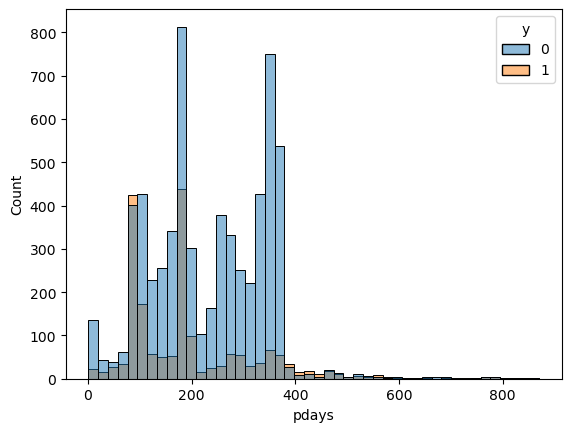

In [46]:
# getting histogram of pdays for previously contacted customers
sns.histplot(df[df.pdays != -1], x = 'pdays', hue = 'y')

<Axes: xlabel='previous', ylabel='Count'>

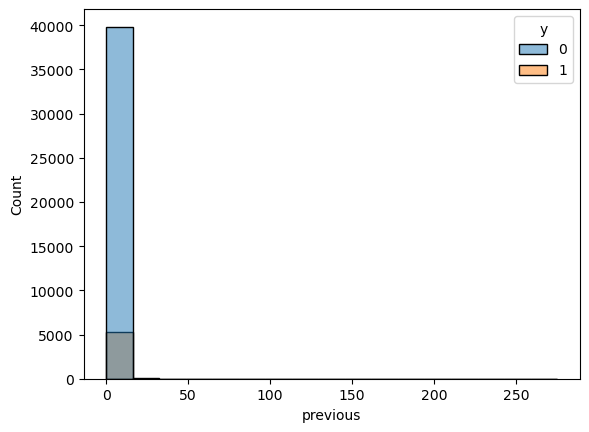

In [47]:
sns.histplot(df, x = 'previous', hue = 'y')

In [48]:
df[df.y == 1].previous.value_counts().sort_index()

0     3384
1      583
2      456
3      294
4      171
5      121
6       83
7       54
8       39
9       24
10      26
11      15
12      10
13       9
14       5
15       1
17       3
19       2
20       1
21       1
22       1
23       1
26       1
29       1
30       1
55       1
58       1
Name: previous, dtype: int64

## Applying Logistic Regression

### with inbalanced data

In [49]:
# creating classification model
clf = LogisticRegression()

In [50]:
# seperating independent and dependent variables
X = df.drop(columns = 'y')
y = df.y

In [51]:
# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
# fitting the model with training data
clf.fit(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
# getting accuracy score with testing data
clf.score(X_test, y_test)

0.8816243475183579

In [54]:
# getting predicted values from our classification model
y_pred = clf.predict(X_test)

In [55]:
# displaying a report with relevant metrics which provide insight into the performance of our model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      9959
           1       0.57      0.02      0.04      1344

    accuracy                           0.88     11303
   macro avg       0.72      0.51      0.49     11303
weighted avg       0.85      0.88      0.83     11303



As we don't want to miss out on customers who will take the term deposit, we don't mind false positives, but absolutely would like to avoid false negatives. If recall is high, then false negatives are low in proportion to true positives.  
Here the recall score is extremely poor, which means we miss out on majority of the customers who would take term deposit

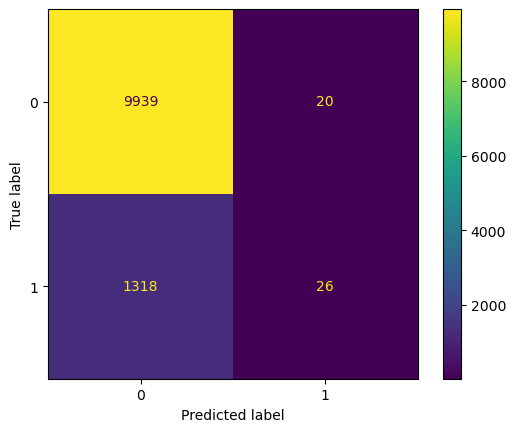

In [56]:
# displaying Confusion Matrix for our model
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

False Negatives are almost all actual true values

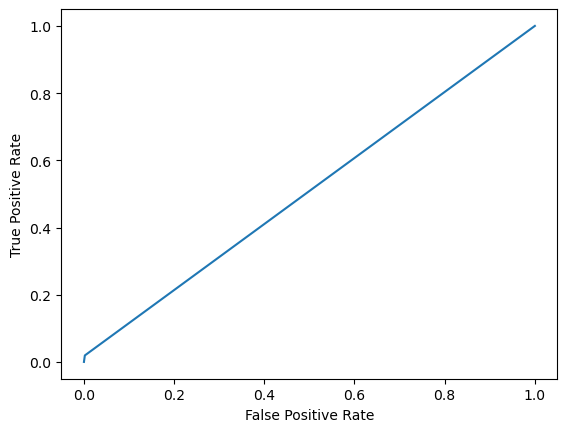

In [57]:
# plotting an ROC curve for our classifier with its optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

In [58]:
# getting actual probabilities for the outcome for each sample, instead of binary classification
y_proba = clf.predict_proba(X_test)[:,1]

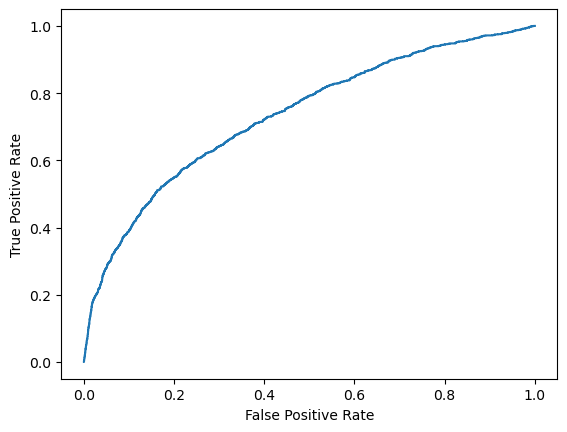

In [59]:
# plotting ROC curve for our model at all thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

### With balanced class weights

Let's try with a balanced weight for each class of the dependent variable

In [60]:
clf = LogisticRegression(class_weight='balanced')

In [61]:
clf.fit(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [62]:
clf.score(X_test, y_test)

0.6923825533044324

In [63]:
y_pred = clf.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80      9959
           1       0.22      0.64      0.33      1344

    accuracy                           0.69     11303
   macro avg       0.58      0.67      0.57     11303
weighted avg       0.85      0.69      0.74     11303



The recall score has increased a lot, however the accuracy score has dropped a little

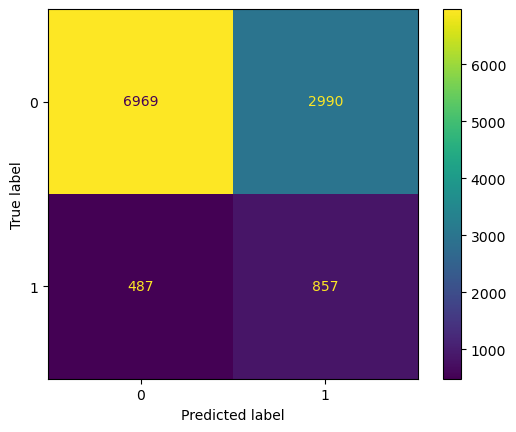

In [65]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

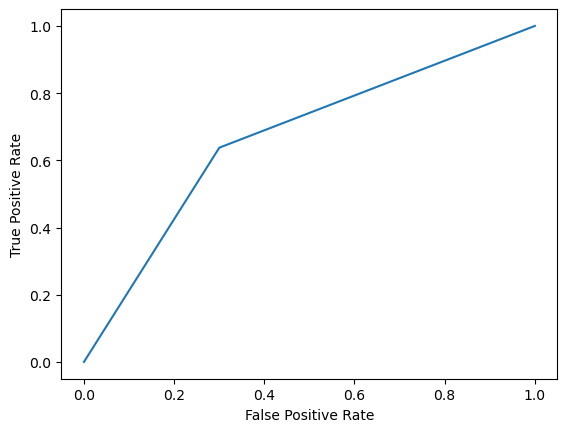

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

In [67]:
y_proba = clf.predict_proba(X_test)[:,1]

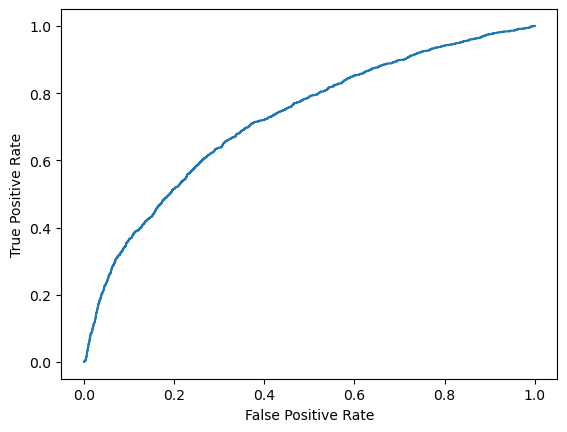

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

This confirms that we should balance the data set

### With numeric features standardized

Now lets try standardizing the data

In [69]:
df2 = df.copy()

In [70]:
df2.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign',
       'pdays', 'previous', 'y', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [71]:
numeric_features = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

In [72]:
# standardizing all numeric features
df2[numeric_features] = StandardScaler().fit_transform(df2[numeric_features])

In [73]:
clf = LogisticRegression(class_weight='balanced')

In [74]:
X = df2.drop(columns = 'y')
y = df2.y

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [76]:
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [77]:
clf.score(X_test, y_test)

0.7502432982394055

In [78]:
y_pred = clf.predict(X_test)

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.77      0.84      9998
           1       0.26      0.63      0.37      1305

    accuracy                           0.75     11303
   macro avg       0.60      0.70      0.61     11303
weighted avg       0.86      0.75      0.79     11303



Recall slightly reduced after standardizing numeric features, although accuracy improved

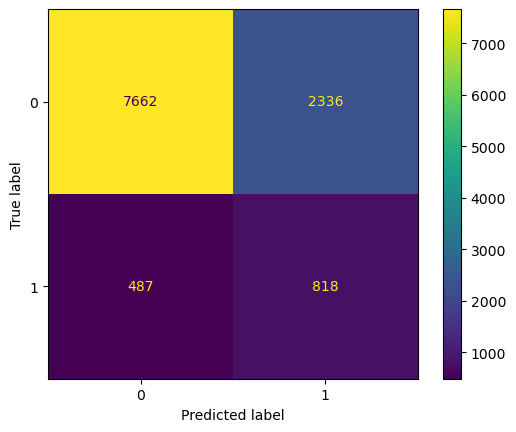

In [80]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

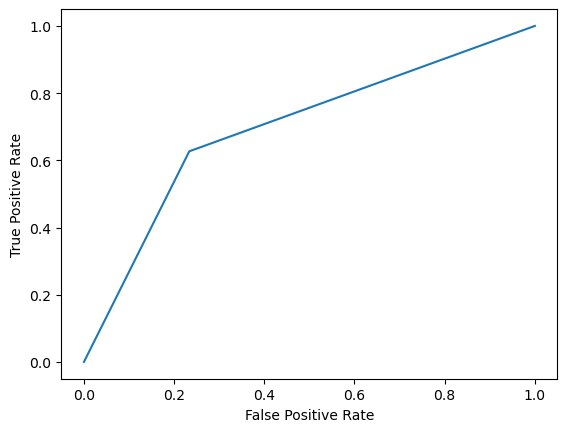

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

In [82]:
y_proba = clf.predict_proba(X_test)[:,1]

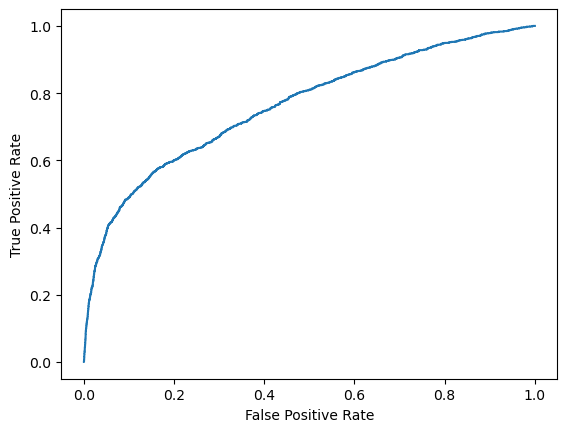

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

### with numeric features normalized

Lets try Normalizing the data

In [84]:
df3 = df.copy()

In [85]:
df3[numeric_features] = Normalizer().fit_transform(df3[numeric_features])

In [86]:
X = df3.drop(columns = 'y')
y = df3.y

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [88]:
clf.fit(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [89]:
clf.score(X_test, y_test)

0.7550207909404583

In [90]:
y_pred = clf.predict(X_test)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85      9978
           1       0.27      0.63      0.38      1325

    accuracy                           0.76     11303
   macro avg       0.60      0.70      0.61     11303
weighted avg       0.86      0.76      0.79     11303



Recall is slightly better than original data with balanced weights, and accuracy has also improved slightly

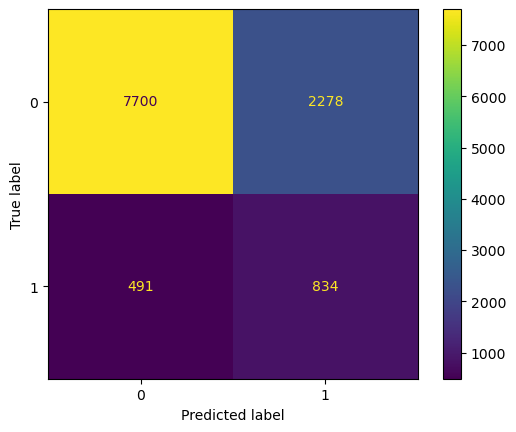

In [92]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

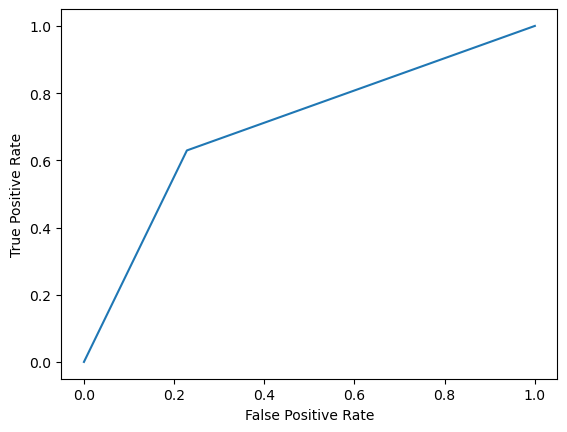

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

In [94]:
y_proba = clf.predict_proba(X_test)[:,1]

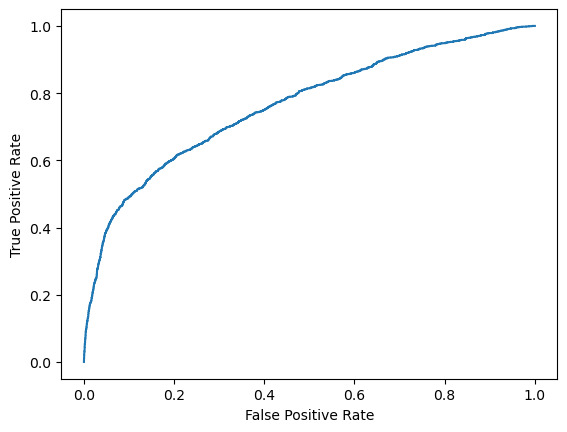

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

### With numeric all numeric features log transformed

In [96]:
df4 = df.copy()

In [97]:
df4[numeric_features].columns

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')

In [98]:
df4[numeric_features].previous.unique()

array([  0,   3,   1,   4,   2,  11,  16,   6,   5,  10,  12,   7,  18,
         9,  21,   8,  14,  15,  26,  37,  13,  25,  20,  27,  17,  23,
        38,  29,  24,  51, 275,  22,  19,  30,  58,  28,  32,  40,  55,
        35,  41], dtype=int64)

In [99]:
# applying log transformation to age feature
df4.age = np.log(df4.age)

In [100]:
# applying log transformation to balance feature; adding 8021 to make all values integers
df4.balance = np.log(df4.balance + 8021)

In [101]:
# applying log transformation to day feature
df4.day = np.log(df4.day)

In [102]:
# applying log transformation to campaign feature
df4.campaign = np.log(df4.campaign)

In [103]:
# applying log transformation to pdays feature; adding 8021 to make all values integers
df4.pdays = np.log(df4.pdays + 2)

In [104]:
# applying log transformation to previous feature; adding 8021 to make all values integers
df4.previous = np.log(df4.previous + 1)

In [105]:
X = df4.drop(columns = 'y')
y = df4.y

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [107]:
clf.fit(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [108]:
clf.score(X_test, y_test)

0.7591789790321154

In [109]:
y_pred = clf.predict(X_test)

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      9960
           1       0.27      0.62      0.38      1343

    accuracy                           0.76     11303
   macro avg       0.61      0.70      0.61     11303
weighted avg       0.86      0.76      0.79     11303



Not the best recall score yet

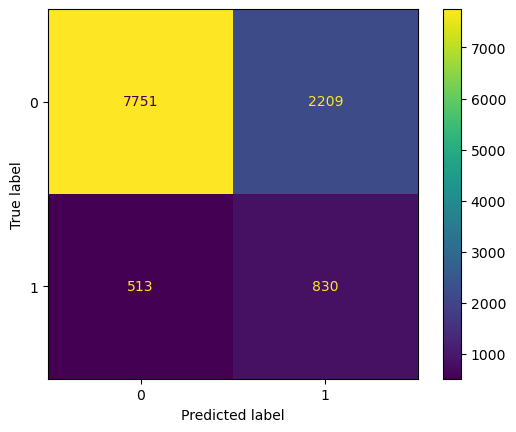

In [111]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

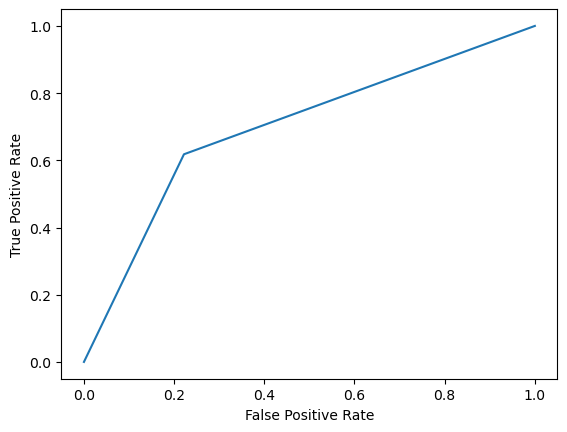

In [112]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

In [113]:
y_proba = clf.predict_proba(X_test)[:,1]

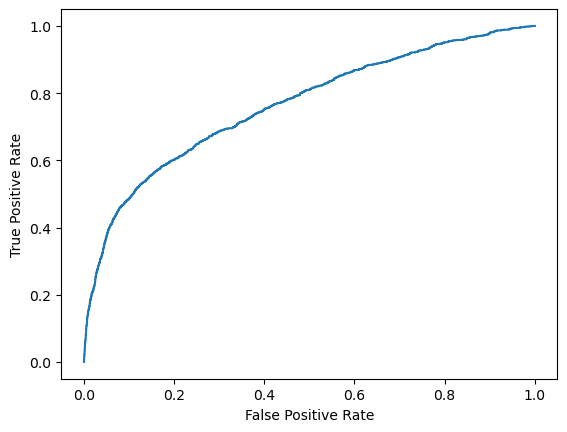

In [114]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

### With only skewed numeric features log transformed

Let's try getting log for only a few features

In [115]:
df5 = df.copy()

In [116]:
df5[numeric_features].columns

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')

C:\Users\harsh\AppData\Local\Temp\ipykernel_9560\3308426416.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5.previous)


<Axes: xlabel='previous', ylabel='Density'>

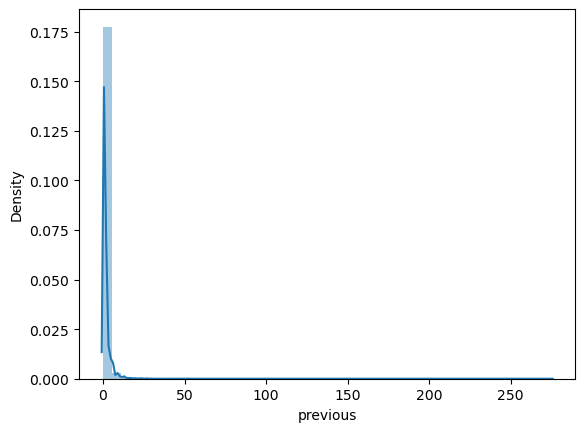

In [117]:
sns.distplot(df5.previous)

In [118]:
# applying log transformation to balance feature; adding 8021 to make all values integers
df5.balance = np.log(df5.balance + 8021)

In [119]:
# applying log transformation to campaign feature
df5.campaign = np.log(df5.campaign)

In [120]:
# applying log transformation to pdays feature; adding 8021 to make all values integers
df5.pdays = np.log(df5.pdays + 2)

In [121]:
# applying log transformation to previous feature; adding 8021 to make all values integers
df5.previous = np.log(df5.previous + 1)

In [122]:
X = df5.drop(columns = 'y')
y = df5.y

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [124]:
clf.fit(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [125]:
clf.score(X_test, y_test)

0.7539591258957798

In [126]:
y_pred = clf.predict(X_test)

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85      9918
           1       0.28      0.62      0.38      1385

    accuracy                           0.75     11303
   macro avg       0.61      0.70      0.61     11303
weighted avg       0.85      0.75      0.79     11303



Not the best recall score yet

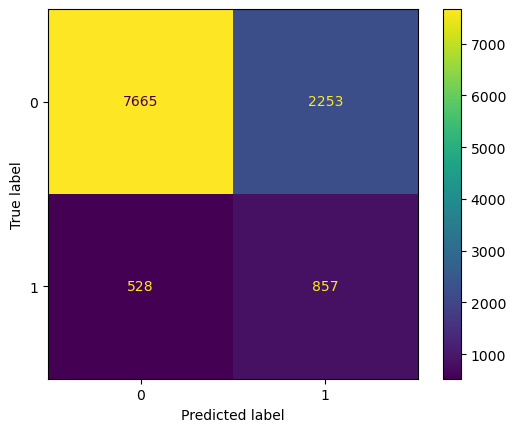

In [128]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

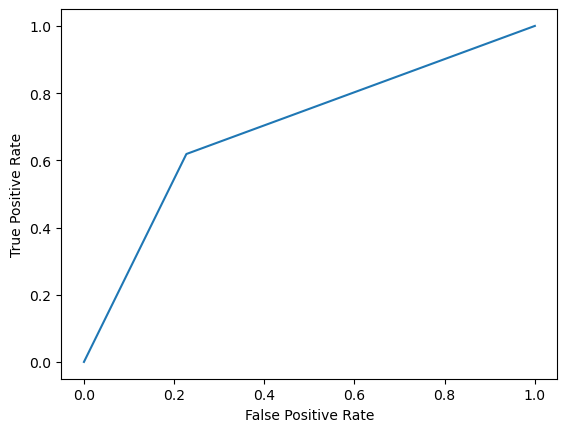

In [129]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

In [130]:
y_proba = clf.predict_proba(X_test)[:,1]

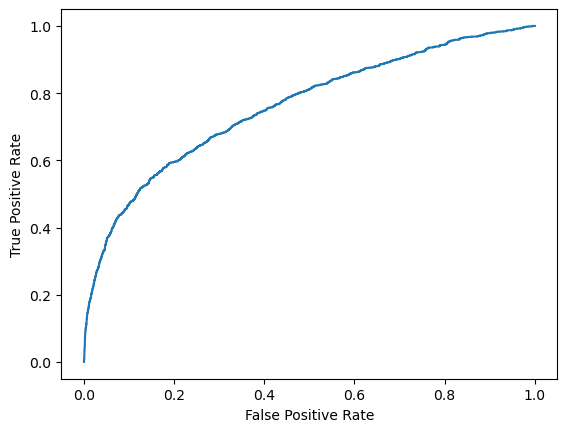

In [131]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

# Considering both accuracy and recall score, class-weight-balanced model built on data with normalized numeric features performs the best with 76% accuracy and 63% recall. Highest recall is 64% for data with no transformations on numeric features, but it has an accuracy of 69%